In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from random import randint
from scipy.optimize import curve_fit
from scipy.stats import poisson
import random

In [2]:
def get_all_files(filename,ending='.root'):
    dir_path = './'

    index=[i+1 for i in range(len(filename)) if  filename[i]=='/']
    if len(index)>0:
        dir_path=filename[:index[-1]]
        filename=filename[index[-1]:]

    res = []
    filelist=os.listdir(dir_path)
    filelist.sort()
    for file in filelist:
        if file.startswith(filename) and file.endswith(ending):
            res.append(f'{dir_path}{file}')
    return res

In [3]:
def df_to_list(xtmp):
    x = []
    for i in range(len(xtmp)):
        str=xtmp[i][1:-1]
        try:
            str.index(',')
            sep=','
        except ValueError:
            sep=' '
        
        tmp=np.fromstring(str, dtype=float, sep=sep)
        x.append(tmp)
    return x


In [4]:
def draw_subplots(xlabel,ylim,yscale='linear',draw_lines='none',ylabel='', radius=[0,100,125,150,175,200,225,250,265]):
    # capture radius for all events
    nrows=int(np.ceil(len(radius)/3))
    ncol=3
    if len(radius)<4:
        ncol=len(radius)
    fig, axss = plt.subplots(nrows, ncol, figsize=(ncol*4,nrows*4),sharex=True)
    axs=axss.reshape(nrows,ncol)
    for i in range(len(radius)):
        idx1=int(i/3)
        idx2=i%3
        if draw_lines=='lines':
            axs[idx1][idx2].axvline(x=0.95,color='lightgray',linestyle='dotted')
            axs[idx1][idx2].axvline(x=2.75,color='lightgray',linestyle='dotted')
            axs[idx1][idx2].axvline(x=3.25,color='lightgray',linestyle='dotted')
            if radius[i] > 0:
                axs[idx1][idx2].axvline(x=radius[i]/100.,color='lightgray',linestyle='dotted')
        if draw_lines=='radius':
            theta = np.arange(0, np.pi * 2, 0.01)
            axs[idx1][idx2].plot(0.95 * np.cos(theta), 0.95 * np.sin(theta),color='black')
            axs[idx1][idx2].plot(2.75 * np.cos(theta), 2.75 * np.sin(theta),color='black')
            axs[idx1][idx2].plot(3.25 * np.cos(theta), 3.25* np.sin(theta),color='black')
            axs[idx1][idx2].plot(5.5 * np.cos(theta), 5.5* np.sin(theta),color='black')
            if radius[i] > 0:
                axs[idx1][idx2].plot(radius[i]/100. * np.cos(theta), radius[i]/100. * np.sin(theta),color='black')
                axs[idx1][idx2].plot((radius[i]/100.+0.1) * np.cos(theta), (radius[i]/100.+0.1) * np.sin(theta),color='black')
        if draw_lines=='rectangle':
            axs[idx1][idx2].set_xlim(-7,7)
            axs[idx1][idx2].set_ylim(-8,5)
            rcryo_inner = plt.Rectangle((-2.75,-3.75), 5.5, 5.5,ec="black",facecolor='none')
            rcryo = plt.Rectangle((-3.25,-4.25), 6.5, 6.5,ec="black",facecolor='none')
            rwater_tank = plt.Rectangle((-5.5,-7.5), 11, 13,ec="black",facecolor='none')
            axs[idx1][idx2].add_patch(rwater_tank)
            axs[idx1][idx2].add_patch(rcryo)
            axs[idx1][idx2].add_patch(rcryo_inner)
            axs[idx1][idx2].set_ylim(-8,6)
            axs[idx1][idx2].set_xlim(-6,6)
        axs[idx1][idx2].set_title(f'r={radius[i]}cm')
        axs[idx1][idx2].set_ylim(ylim[0],ylim[1])
        axs[idx1][idx2].set_yscale(yscale)
        axs[idx1][idx2].set_ylabel(ylabel)
        if idx1==nrows-1:
            axs[idx1][idx2].set_xlabel(xlabel)
        if idx2==0:
            axs[idx1][idx2].set_ylabel(ylabel)
    return [fig,axs]

In [5]:
def read_csv(filenames,ending='.csv'):
    files=get_all_files(filenames,ending)
    nCA = []
    nCZ = []
    cross_cryo = []
    print(f"Reading in data... ({files})")
    #df_in = []
    for file in tqdm(files):
        df_in = pd.read_csv(file,skiprows=1)
    #    print(df_in)
        df_in.to_numpy()

        nCA.extend(df_in['nC_A'].to_numpy())
        nCZ.extend(df_in['nC_Z'].to_numpy())
        cross_cryo.extend(df_in['cross_cryo'].to_numpy())
    return [nCA,nCZ,cross_cryo]

In [6]:
def read_design_parameters(filenames,ending='.csv'):
    files=get_all_files(filenames,ending)
    params = []
    for idx,file in enumerate(files):
        with open(file) as f:
            first_line = f.readline()
            first_line=first_line[first_line.find('[')+1:first_line.find(']')]
            x = [k for k in first_line.split(",")]
            if idx==0:
                params=x
            elif idx > 0 and params!=x:
                print(f"Error {files[idx-1]} and {files[idx]} don't have the same parameters")
    return params

In [7]:

nSamples=303
version = 'v6'
if not os.path.exists(f'out/{version}'):
   os.makedirs(f'out/{version}')
nCA = []
nCZ = []
iidx = []
nprimaries = []
cross_cryo = []
nLF=0
sim_mode = []
radius = []
design = []
thickness = []
theta = []
phi = []
npanels = []
Length = []
zpos = []
volume = []
height = []


for m in range(0,nSamples):
    #filename=f'../simulation/out/LF/{version}/scans_5dim/neutron-sim-D4-LF-{m}_'
    filename=f'../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-{m}_'
    tmp=np.array(read_design_parameters(filename))
    sim_mode.append(tmp[0])
    design.append(float(tmp[1]))
    radius.append(float(tmp[2]))
    height.append(float(tmp[8]))
    thickness.append(float(tmp[3]))
    volume.append(float(tmp[10]))
    Length.append(float(tmp[7]))
    theta.append(float(tmp[6]))
    zpos.append(float(tmp[9]))
    npanels.append(float(tmp[4]))
    phi.append(float(tmp[5])/np.pi*180.)
    [nCA000,nCZ000,cross_cryo000] = read_csv(filename)
    nprimaries.append(25000*len(get_all_files(filename,ending='.csv')))
    iidx.append(len(nCA))
    nCA.extend(nCA000)
    nCZ.extend(nCZ000)
    cross_cryo.extend(cross_cryo000)
    nLF+=1


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-0_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-0_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.02it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-1_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-1_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-2_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-2_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.72it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-3_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-3_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.62it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-4_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-4_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-5_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-5_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-6_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-6_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.03it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-7_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-7_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-8_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-8_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-9_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-9_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-10_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-10_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-11_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-11_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-12_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-12_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.06it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-13_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-13_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-14_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-14_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-15_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-15_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-16_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-16_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-17_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-17_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-18_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-18_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-19_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-19_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-20_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-20_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-21_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-21_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-22_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-22_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-23_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-23_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.43it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-24_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-24_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.35it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-25_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-25_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-26_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-26_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.21it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-27_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-27_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-28_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-28_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.54it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-29_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-29_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.58it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-30_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-30_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-31_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-31_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-32_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-32_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-33_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-33_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-34_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-34_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.07it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-35_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-35_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-36_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-36_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-37_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-37_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-38_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-38_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-39_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-39_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-40_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-40_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.92it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-41_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-41_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-42_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-42_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-43_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-43_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-44_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-44_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-45_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-45_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-46_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-46_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-47_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-47_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.83it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-48_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-48_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.42it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-49_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-49_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-50_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-50_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.51it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-51_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-51_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.35it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-52_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-52_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 17.23it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-53_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-53_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.72it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-54_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-54_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-55_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-55_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-56_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-56_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-57_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-57_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-58_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-58_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-59_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-59_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.07it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-60_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-60_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-61_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-61_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.85it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-62_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-62_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-63_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-63_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.29it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-64_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-64_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-65_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-65_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-66_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-66_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-67_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-67_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-68_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-68_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-69_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-69_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-70_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-70_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-71_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-71_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.95it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-72_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-72_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-73_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-73_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.42it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-74_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-74_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.81it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-75_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-75_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.65it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-76_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-76_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 15.32it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-77_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-77_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.07it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-78_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-78_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-79_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-79_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.75it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-80_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-80_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-81_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-81_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.68it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-82_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-82_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-83_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-83_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-84_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-84_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-85_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-85_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-86_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-86_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-87_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-87_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.10it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-88_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-88_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.83it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-89_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-89_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-90_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-90_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-91_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-91_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-92_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-92_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-93_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-93_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-94_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-94_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-95_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-95_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-96_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-96_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.04it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-97_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-97_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.88it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-98_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-98_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-99_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-99_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.82it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-100_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-100_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.84it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-101_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-101_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.68it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-102_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-102_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-103_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-103_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.16it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-104_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-104_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.89it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-105_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-105_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-106_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-106_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-107_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-107_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.60it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-108_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-108_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-109_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-109_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-110_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-110_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.97it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-111_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-111_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-112_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-112_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-113_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-113_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-114_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-114_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-115_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-115_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-116_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-116_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-117_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-117_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-118_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-118_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-119_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-119_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-120_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-120_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-121_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-121_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.10it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-122_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-122_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.95it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-123_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-123_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.15it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-124_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-124_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.57it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-125_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-125_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 15.18it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-126_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-126_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-127_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-127_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-128_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-128_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.40it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-129_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-129_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.70it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-130_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-130_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.32it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-131_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-131_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-132_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-132_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.79it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-133_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-133_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.38it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-134_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-134_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-135_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-135_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.79it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-136_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-136_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-137_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-137_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-138_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-138_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-139_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-139_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.11it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-140_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-140_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.98it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-141_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-141_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-142_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-142_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-143_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-143_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-144_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-144_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.71it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-145_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-145_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-146_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-146_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.42it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-147_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-147_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.95it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-148_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-148_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.69it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-149_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-149_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.03it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-150_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-150_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.72it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-151_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-151_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 15.00it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-152_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-152_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-153_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-153_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.26it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-154_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-154_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.42it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-155_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-155_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 15.07it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-156_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-156_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.45it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-157_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-157_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.33it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-158_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-158_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.33it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-159_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-159_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-160_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-160_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 15.01it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-161_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-161_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-162_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-162_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.21it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-163_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-163_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.85it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-164_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-164_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 15.32it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-165_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-165_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.87it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-166_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-166_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.59it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-167_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-167_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-168_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-168_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.45it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-169_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-169_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-170_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-170_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.12it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-171_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-171_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-172_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-172_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-173_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-173_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-174_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-174_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-175_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-175_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-176_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-176_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.89it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-177_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-177_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-178_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-178_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.44it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-179_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-179_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-180_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-180_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-181_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-181_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.31it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-182_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-182_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-183_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-183_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-184_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-184_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-185_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-185_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.67it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-186_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-186_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-187_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-187_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-188_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-188_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-189_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-189_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-190_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-190_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-191_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-191_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.06it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-192_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-192_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-193_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-193_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-194_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-194_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.64it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-195_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-195_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-196_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-196_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-197_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-197_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-198_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-198_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-199_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-199_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.13it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-200_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-200_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-201_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-201_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-202_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-202_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.75it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-203_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-203_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-204_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-204_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-205_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-205_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-206_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-206_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-207_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-207_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-208_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-208_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-209_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-209_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-210_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-210_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-211_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-211_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-212_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-212_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.25it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-213_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-213_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.23it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-214_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-214_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 15.62it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-215_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-215_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 16.98it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-216_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-216_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 16.48it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-217_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-217_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 15.64it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-218_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-218_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.26it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-219_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-219_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.16it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-220_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-220_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.93it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-221_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-221_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-222_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-222_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-223_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-223_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-224_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-224_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.81it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-225_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-225_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.88it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-226_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-226_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-227_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-227_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.38it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-228_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-228_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.40it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-229_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-229_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.68it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-230_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-230_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.66it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-231_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-231_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-232_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-232_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.60it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-233_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-233_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.94it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-234_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-234_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.99it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-235_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-235_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.01it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-236_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-236_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-237_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-237_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-238_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-238_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-239_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-239_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-240_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-240_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.47it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-241_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-241_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-242_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-242_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.35it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-243_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-243_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-244_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-244_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-245_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-245_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-246_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-246_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.77it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-247_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-247_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-248_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-248_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-249_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-249_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-250_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-250_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.59it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-251_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-251_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-252_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-252_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-253_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-253_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.46it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-254_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-254_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-255_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-255_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.85it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-256_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-256_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.77it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-257_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-257_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 15.02it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-258_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-258_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 15.52it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-259_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-259_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 15.86it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-260_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-260_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.55it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-261_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-261_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-262_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-262_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.57it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-263_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-263_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-264_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-264_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.45it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-265_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-265_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.91it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-266_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-266_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.01it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-267_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-267_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.53it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-268_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-268_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.80it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-269_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-269_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.09it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-270_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-270_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-271_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-271_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-272_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-272_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.46it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-273_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-273_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.37it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-274_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-274_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.89it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-275_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-275_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.07it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-276_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-276_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.63it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-277_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-277_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.92it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-278_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-278_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.35it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-279_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-279_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.87it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-280_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-280_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-281_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-281_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-282_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-282_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-283_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-283_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-284_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-284_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 12.05it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-285_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-285_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.88it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-286_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-286_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.45it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-287_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-287_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.24it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-288_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-288_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 13.57it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-289_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-289_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 11.79it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-290_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-290_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 10.86it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-291_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-291_0001.csv'])


100%|██████████| 2/2 [00:00<00:00, 14.51it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-292_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-292_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-293_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-293_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-294_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-294_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  7.89it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-295_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-295_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-296_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-296_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-297_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-297_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-298_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-298_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-299_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-299_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-300_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-300_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.03it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-301_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-301_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Reading in data... (['../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-302_0000.csv', '../simulation/out/LF/v2/scans_5dim/neutron-sim-D4-LF-302_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


In [8]:
# read in HF simulations
hf_sims=[0,1,2]
nHF=len(hf_sims)
for i,m in enumerate(hf_sims):
    filename=f'../simulation/out/HF/v2/Neutron-Simulation-Design{m}/neutron-sim-design{m}'
    tmp=read_design_parameters(filename)
    sim_mode.append(tmp[0])
    design.append(float(tmp[1]))
    radius.append(float(tmp[2]))
    height.append(float(tmp[7]))
    thickness.append(float(tmp[3]))
    volume.append(float(tmp[9]))
    Length.append(float(tmp[6]))
    phi.append(float(tmp[4]))
    theta.append(float(tmp[5]))
    zpos.append(float(tmp[8]))
    npanels.append(360)
    [nCA000,nCZ000,cross_cryo000] = read_csv(filename)
    nprimaries.append(50000*len(get_all_files(filename,ending='.csv')))
    iidx.append(len(nCA))
    nCA.extend(nCA000)
    nCZ.extend(nCZ000)
    cross_cryo.extend(cross_cryo000)


Reading in data... (['../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-design0_0000.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-design0_0002.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-design0_0003.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-design0_0004.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-design0_0005.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-design0_0006.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-design0_0007.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-design0_0008.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-design0_0010.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-design0_0011.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-design0_0012.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design0/neutron-sim-de

100%|██████████| 202/202 [00:05<00:00, 38.48it/s]


Reading in data... (['../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-design1_0000.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-design1_0002.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-design1_0003.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-design1_0004.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-design1_0005.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-design1_0006.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-design1_0007.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-design1_0008.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-design1_0009.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-design1_0010.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-design1_0011.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design1/neutron-sim-de

100%|██████████| 185/185 [00:05<00:00, 35.22it/s]


Reading in data... (['../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-design2_0002.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-design2_0003.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-design2_0004.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-design2_0005.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-design2_0006.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-design2_0007.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-design2_0008.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-design2_0009.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-design2_0010.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-design2_0011.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-design2_0012.csv', '../simulation/out/HF/v2/Neutron-Simulation-Design2/neutron-sim-de

100%|██████████| 193/193 [00:06<00:00, 30.78it/s]


In [9]:
iidx.append(len(nCA))

In [10]:
scaling=1.365
Ge77factor=2599.8512051851676*scaling
Ge77factor_err=52.446566098836236*scaling
Ge77LFscaling=1494984/10100000
Ge77LFscaling_err=np.sqrt(1494984)/10100000
Ge77HFscaling=1

def fNPrimariesLF(scaling, n_neutrons):
    return n_neutrons/scaling
def fGe77Rate(nCZ,Ge77factor,nprimaries):
    return nCZ*(Ge77factor/nprimaries)

In [11]:
def monte_carlo_simulations(rate_mean, rate_std, n_iter=10000):
    outputs = []
    for i in range(n_iter):
        result = random.normalvariate(rate_mean, rate_std)
        outputs.append(result)
    return outputs

def gauss(x, A, mean, sigma):
    return A * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

def Ge77MonteCarlosSim(nevt,Ge77factor,nprimaries):
    nevt_std=np.sqrt(nevt)
    events = monte_carlo_simulations(nevt,nevt_std)
    results = [fGe77Rate(k,Ge77factor,nprimaries) for k in events]
    values, bins = np.histogram(results, bins=100)    
    x = (bins[:-1] + bins[1:]) / 2
    #plt.scatter(x,values)
    parameters, covariance = curve_fit(gauss, x, values, p0 = [250, fGe77Rate(nevt,Ge77factor,nprimaries), fGe77Rate(nevt_std,Ge77factor,nprimaries)])
    #plt.plot(x,gauss(x,parameters[0],parameters[1],parameters[2]))
    return parameters[2]

In [12]:
Ge77 = []
Ge77err = []
Ge77Rate_err = []
Ge77Rate = []
Ge77Rate1 = []
n_neutrons = []
Ge77Eff_err = []
Ge77Eff = []
Ge77Rate_err_stat = []

for j in range(len(iidx)-1):
    itmp=int(j/3)
    iitmp=int(j%3)
    length=iidx[j+1]-iidx[j]

    #nCZtmp2=[nCZ[i] for i in range(iidx[j],iidx[j+1],1) if nCZ[i]==32 and nCA[i]==77]
    nCGe77=len([nCZ[i] for i in range(iidx[j],iidx[j+1],1) if nCZ[i]==32 and nCA[i]==77 and cross_cryo[i]!=-1])
    nneutrons=len([cross_cryo[i] for i in range(iidx[j],iidx[j+1],1) if cross_cryo[i]!=-1])
    GeEvents = []

    if j < nLF:
        n_neutrons.append(length)
        nprims=length/Ge77LFscaling

        err_x3=nCGe77*(Ge77factor*Ge77LFscaling/(n_neutrons[j]**2))*np.sqrt(n_neutrons[j])
        err_x4=nCGe77*(Ge77factor*Ge77LFscaling_err/n_neutrons[j])
        

    else:
        n_neutrons.append(nneutrons)
        nprims=nprimaries[j]
        err_x3=nCGe77*(Ge77factor/(nprims**2))*np.sqrt(nprims)
        err_x4=0

    err_x1=np.sqrt(nCGe77)*(Ge77factor/nprims)
    err_x2=nCGe77*(Ge77factor_err/nprims)
    
    err_xx1=np.sqrt(nCGe77)/nneutrons
    err_xx2=nCGe77/nneutrons**2*np.sqrt(nneutrons)

    Ge77Rate_err_stat.append(Ge77MonteCarlosSim(nCGe77,Ge77factor,nprims))

    Ge77.append(nCGe77)
    Ge77err.append(np.sqrt(nCGe77))
    Ge77Rate.append(fGe77Rate(nCGe77,Ge77factor,nprims))
    Ge77Rate_err.append(np.sqrt(err_x1**2+err_x2**2+err_x3**2+err_x4**2))
    Ge77Eff.append(Ge77[j]/nneutrons)
    Ge77Eff_err.append(np.sqrt(err_xx1**2+err_xx2**2))



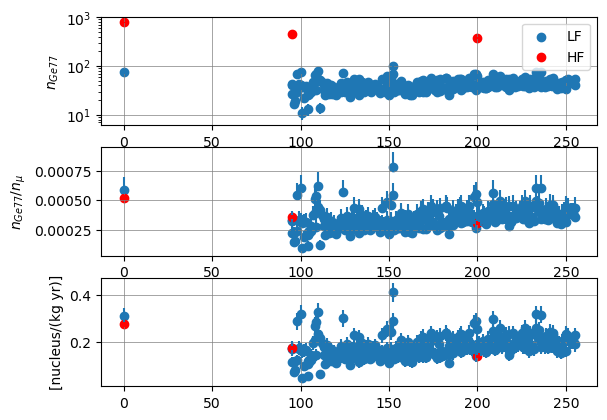

In [13]:
fig, (ax1,ax2,ax3)= plt.subplots(3,1)
ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax1.errorbar(radius[0:nLF],np.array(np.array(Ge77))[0:nLF],np.array(np.sqrt(np.array(Ge77)))[0:nLF],ls='none')
ax1.scatter(radius[0:nLF],np.array(np.array(Ge77))[0:nLF],label='LF')
ax1.errorbar(radius[nLF:],np.array(np.array(Ge77))[nLF:],np.array(np.sqrt(np.array(Ge77)))[nLF:],ls='none',color='red')
ax1.scatter(radius[nLF:],np.array(np.array(Ge77))[nLF:],color='red',label='HF')
ax1.set_ylabel('$n_{Ge77}$')
ax1.set_yscale('log')
ax1.legend(loc='upper right')

ax2.grid(color='gray', linestyle='-', linewidth=0.5)
ax2.errorbar(radius[0:-nHF],Ge77Eff[0:-nHF],Ge77Eff_err[0:-nHF],ls='none')
ax2.scatter(radius[0:-nHF],np.array(np.array(Ge77)/np.array(n_neutrons))[0:-nHF],label='LF')
ax2.errorbar(radius[-nHF:],Ge77Eff[-nHF:],Ge77Eff_err[-nHF:],ls='none',color='red')
ax2.scatter(radius[-nHF:],np.array(np.array(Ge77)/np.array(n_neutrons))[-nHF:],color='red',label='HF')
ax2.set_ylabel('$n_{Ge77}/n_\mu$')


ax3.grid(color='gray', linestyle='-', linewidth=0.5)
ax3.scatter(radius[0:-nHF],Ge77Rate[0:-nHF],label='LF')
ax3.errorbar(radius[0:-nHF],Ge77Rate[0:-nHF],Ge77Rate_err[0:-nHF],ls='none')

ax3.errorbar(radius[-nHF:],Ge77Rate[-nHF:],Ge77Rate_err[-nHF:],ls='none',color='red')
ax3.scatter(radius[-nHF:],Ge77Rate[-nHF:],color='red',label='HF')
ax3.set_ylabel('[nucleus/(kg yr)]')
fig.savefig(f'out/{version}/neutron-Ge77-capture-comparision_{version}.png')

In [14]:
#np.set_printoptions(threshold=sys.maxsize)
df = pd.DataFrame({'Mode': sim_mode, 'Design': design, 'Radius[cm]': radius, 'Thickness[cm]': thickness, 'NPanels': npanels, 'Phi[deg]': phi, 'Theta[deg]': theta, 'Length[cm]':Length, 'Height[cm]': height, 'ZPosition[cm]':zpos, 'Volume[cm3]':volume, 'Ge-77[nevents]':Ge77, 'Ge-77_err[nevents]':np.sqrt(np.array(Ge77)), 'Ge77-Eff': Ge77Eff, 'Ge77-Eff_err': Ge77Eff_err, 'Ge77-Rate[nucleus/(kg yr)]': Ge77Rate, 'Ge77-Rate_err[nucleus/(kg yr)]': Ge77Rate_err, 'Ge77-Rate_err_stat[nucleus/(kg yr)]': Ge77Rate_err_stat, 'nprimaries':nprimaries, 'total_neutrons': n_neutrons})
df

,Mode,Design,Radius[cm],Thickness[cm],NPanels,Phi[deg],Theta[deg],Length[cm],Height[cm],ZPosition[cm],Volume[cm3],Ge-77[nevents],Ge-77_err[nevents],Ge77-Eff,Ge77-Eff_err,Ge77-Rate[nucleus/(kg yr)],Ge77-Rate_err[nucleus/(kg yr)],Ge77-Rate_err_stat[nucleus/(kg yr)],nprimaries,total_neutrons
0,LF,4.0,124.0,16.0,196.0,105.237146,18.0,3.0,300.0,42.0,4792806.91,37,6.082763,0.000319,0.000052,0.157468,0.026086,0.025432,50000,123426
1,LF,4.0,200.0,7.0,230.0,89.680351,27.0,134.0,300.0,42.0,66606597.45,41,6.403124,0.000391,0.000061,0.192992,0.030397,0.029726,50000,111594
2,LF,4.0,139.0,8.0,95.0,217.120849,4.0,17.0,300.0,42.0,4962186.81,31,5.567764,0.000264,0.000047,0.130581,0.023604,0.023319,50000,124703
3,LF,4.0,198.0,7.0,357.0,57.777257,28.0,45.0,300.0,42.0,35584856.04,40,6.324555,0.000358,0.000057,0.176968,0.028213,0.027981,50000,118730
4,LF,4.0,116.0,11.0,67.0,307.857920,7.0,144.0,300.0,42.0,32953156.45,29,5.385165,0.000254,0.000047,0.125613,0.023466,0.023465,50000,121272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,LF,3.0,200.0,10.0,360.0,0.000000,0.0,3.5,300.0,42.0,4702964.00,39,6.244998,0.000340,0.000055,0.168672,0.027227,0.026511,50000,121456
302,LF,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,76,8.717798,0.000626,0.000072,0.308966,0.035996,0.034959,50000,129211
303,HF,0.0,0.0,0.0,360.0,0.000000,0.0,0.0,0.0,0.0,42.00,780,27.928480,0.000522,0.000019,0.274066,0.011264,0.009900,10100000,1494984
304,HF,3.0,95.0,10.0,360.0,360.000000,0.0,0.0,1.7,300.0,42.00,456,21.354157,0.000359,0.000017,0.174946,0.008921,0.008166,9250000,1269722


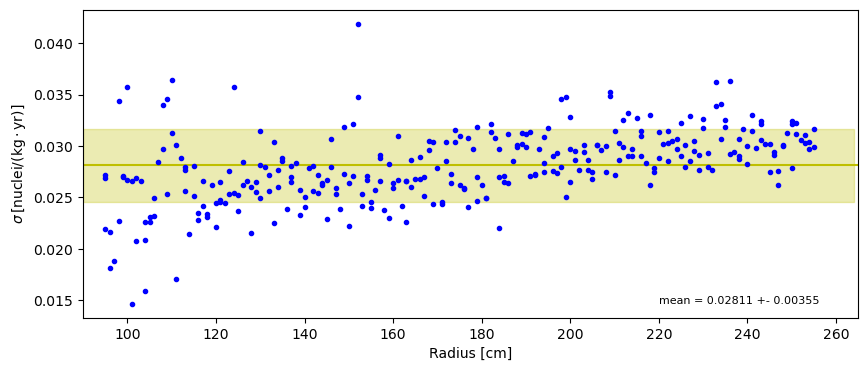

In [31]:

values, bins = np.histogram(Ge77Rate_err_stat[0:nLF], bins=10)    
x = (bins[:-1] + bins[1:]) / 2
#plt.scatter(x,values)
plt.figure(figsize=(10,4))
plt.axhline(y = np.mean(Ge77Rate_err_stat[0:nLF]), color = 'y')
plt.plot(radius[0:nLF],Ge77Rate_err_stat[0:nLF],'b',marker=".",linewidth=0)

# only one line may be specified; full height

ymin=np.mean(Ge77Rate_err_stat[0:nLF])-1*np.std(Ge77Rate_err_stat[0:nLF])
ymax=np.mean(Ge77Rate_err_stat[0:nLF])+1*np.std(Ge77Rate_err_stat[0:nLF])
x=[i for i in range(90,265)]
y1=[ymin for i in range(90,265)]
y2=[ymax for i in range(90,265)]
plt.fill_between(x,y1,y2,color='y', alpha=0.3)
plt.xlim(90.,265.)
plt.xlabel('Radius [cm]')
plt.ylabel(r'$\sigma\,\rm [nuclei/(kg \cdot yr)]$')
err_min=np.min(Ge77Rate_err_stat[0:nLF])*1.
plt.text(220,err_min,f"mean = {np.round(np.mean(Ge77Rate_err_stat[0:nLF]),5)} +- {np.round(np.std(Ge77Rate_err_stat[0:nLF]),5)}",fontsize=8)
plt.savefig(f"out/{version}/noise_LF_{version}.png")

In [29]:
f=open(f'out/{version}/Ge77_rates_{version}.csv',"w")
f.write(f"# LF noise: mean = {np.mean(Ge77Rate_err_stat[0:nLF])} +- {np.std(Ge77Rate_err_stat[0:nLF])}"+"\n")
f.close()
df.to_csv(f'out/{version}/Ge77_rates_{version}.csv',mode='a')